In [1]:
%load_ext autoreload
%autoreload 2

# Density at 150 pc - pericenter relation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

from density_profile_utils import calculate_rho_s, calculate_r_s, calculate_M200, calculate_R200, NFW_profile, mass, rho_mean, calculate_error_NFW_rho
from density_pericenter_fit_utils import run_best_fit, log_model

plt.style.use("pltstyle.mplstyle")
params = {
    "font.size": 10,
    "font.family": "Times",
    "text.usetex": True,
    "figure.figsize": (5, 2.5),
    "figure.subplot.left": 0.1,
    "figure.subplot.right": 0.95,
    "figure.subplot.bottom": 0.16,
    "figure.subplot.top": 0.95,
    "figure.subplot.wspace": 0.3,
    "figure.subplot.hspace": 0.3,
    "lines.markersize": 2,
    "lines.linewidth": 1.5,
}
plt.rcParams.update(params)

## Gaia data with NFW fit

In [3]:
GAIA_PATH = "../data/Gaia/"
Kaplinghat_data = pd.read_csv(GAIA_PATH+"Kaplinghat_2019.csv").to_numpy()

dSph = Kaplinghat_data[:,0]
dSph = dSph[::2]

Vmax = Kaplinghat_data[:,2]
le_Vmax = Kaplinghat_data[:,2] + Kaplinghat_data[:,3]
he_Vmax = Kaplinghat_data[:,2] + Kaplinghat_data[:,4]
NFW_Vmax = 10**Vmax[::2] # Only NFW fit data; [km/s] units
le_NFW_Vmax = NFW_Vmax - 10**le_Vmax[::2] # Only NFW fit data; [km/s] units
he_NFW_Vmax = 10**he_Vmax[::2] - NFW_Vmax # Only NFW fit data; [km/s] units

Rmax = Kaplinghat_data[:,5]
le_Rmax = Kaplinghat_data[:,6] + Kaplinghat_data[:,5]
he_Rmax = Kaplinghat_data[:,7] + Kaplinghat_data[:,5]
NFW_Rmax = 10**Rmax[::2] # Only NFW fit data; [kpc] units
le_NFW_Rmax = NFW_Rmax - 10**le_Rmax[::2]  # Only NFW fit data; [kpc] units
he_NFW_Rmax = 10**he_Rmax[::2] - NFW_Rmax  # Only NFW fit data; [kpc] units
he_NFW_Rmax /= 2 # Reducing uncertainty in Rmax by factor of 2
le_NFW_Rmax /= 2 # Reducing uncertainty in Rmax by factor of 2

num_satellites = len(NFW_Rmax)
M200_K19 = np.zeros((3,num_satellites))
R200_K19 = np.zeros((3,num_satellites))

rho_s = np.zeros(num_satellites)
r_s = np.zeros(num_satellites)
r_range = np.arange(-4, 4, 0.01) # Some radial range
r_range = 10**r_range # to kpc

for i in range(num_satellites):
    rho_s[i] = calculate_rho_s(NFW_Vmax[i], NFW_Rmax[i])
    r_s[i] = calculate_r_s(NFW_Rmax[i])
    rho = NFW_profile(r_range, rho_s[i], r_s[i])
    mass_within_r = mass(rho, r_range)
    rho_within_r = rho_mean(mass_within_r, r_range)
    R200_K19[0, i] = calculate_R200(rho_within_r, r_range)
    M200_K19[0, i] = calculate_M200(R200_K19[0, i])

    ## Dealing with error propagration..
    low_error_rho = rho - calculate_error_NFW_rho(r_range, NFW_Vmax[i], NFW_Rmax[i], le_NFW_Vmax[i], le_NFW_Rmax[i])
    mass_within_r = mass(low_error_rho, r_range)
    rho_within_r = rho_mean(mass_within_r, r_range)
    R200_K19[1, i] = calculate_R200(rho_within_r, r_range)
    M200_K19[1, i] = M200_K19[0, i] - calculate_M200(R200_K19[1, i])

    high_error_rho = rho + calculate_error_NFW_rho(r_range, NFW_Vmax[i], NFW_Rmax[i], he_NFW_Vmax[i], he_NFW_Rmax[i])
    mass_within_r = mass(high_error_rho, r_range)
    rho_within_r = rho_mean(mass_within_r, r_range)
    R200_K19[2, i] = calculate_R200(rho_within_r, r_range)
    M200_K19[2, i] = calculate_M200(R200_K19[2, i]) - M200_K19[0, i]

In [4]:
# We remove CVnI
num_satellites -= 1
dSph = dSph[:-1]

r_p_Isolated = np.zeros((3,num_satellites)) # Reading pericenter assuming isolated MW
r_p_LMC = np.zeros((3,num_satellites))      # Reading pericenter assuming MW perturbed by LMC
rho_150pc_K19 = np.zeros((3,num_satellites)) # Reading Kaplinghat+ 2019 determination under NFW


for i, dSphi in enumerate(dSph):
    filename = "Cardona_2023_"+dSphi+".csv"
    data = pd.read_csv(GAIA_PATH + filename).to_numpy()
    r_p_Isolated[0,i] = data[2,0] # Pericenter [kpc]
    r_p_Isolated[1,i] = data[2,1] # (Error) Pericenter [kpc]
    r_p_Isolated[2,i] = data[2,2] # (Error) Pericenter [kpc]
    r_p_LMC[0,i] = data[3,0] # Pericenter [kpc]
    r_p_LMC[1,i] = data[3,1] # Pericenter [kpc]
    r_p_LMC[2,i] = data[3,2] # Pericenter [kpc]
    rho_150pc_K19[0,i] = data[8,0] * 1e7 # Central density [Msun/kpc^3]
    rho_150pc_K19[1,i] = data[8,1] * 1e7 # Central density [Msun/kpc^3]
    rho_150pc_K19[2,i] = data[8,2] * 1e7 # Central density [Msun/kpc^3]

Fit

In [5]:
samples_isolated = run_best_fit(r_p_Isolated, rho_150pc_K19)
samples_LMC = run_best_fit(r_p_LMC, rho_150pc_K19)

def get_q_m_from_samples(samples):
    q = np.median(samples[:, 0])
    m = np.median(samples[:, 1])
    qerrl = np.percentile(samples[:, 0], 16)
    qerrh = np.percentile(samples[:, 0], 84)
    merrl = np.percentile(samples[:, 1], 16)
    merrh = np.percentile(samples[:, 1], 84)
    return q, m, qerrl, qerrh, merrl, merrh

q_isolated, m_isolated, qerrl_isolated, qerrh_isolated, merrl_isolated, merrh_isolated = get_q_m_from_samples(samples_isolated)
q_LMC, m_LMC, qerrl_LMC, qerrh_LMC, merrl_LMC, merrh_LMC = get_q_m_from_samples(samples_LMC)

2.6718527922317876 -0.8753657760667156


100%|██████████| 5000/5000 [00:06<00:00, 740.74it/s]

Multiprocessing took 0.1 minutes
Mean autocorrelation time: 34.703 steps
2.0560949162314808 -0.48709254257326656



100%|██████████| 5000/5000 [00:06<00:00, 748.53it/s]


Multiprocessing took 0.1 minutes
Mean autocorrelation time: 38.756 steps


Plot

(50000000.0, 10000000000.0, 10000000.0, 1000000000.0)

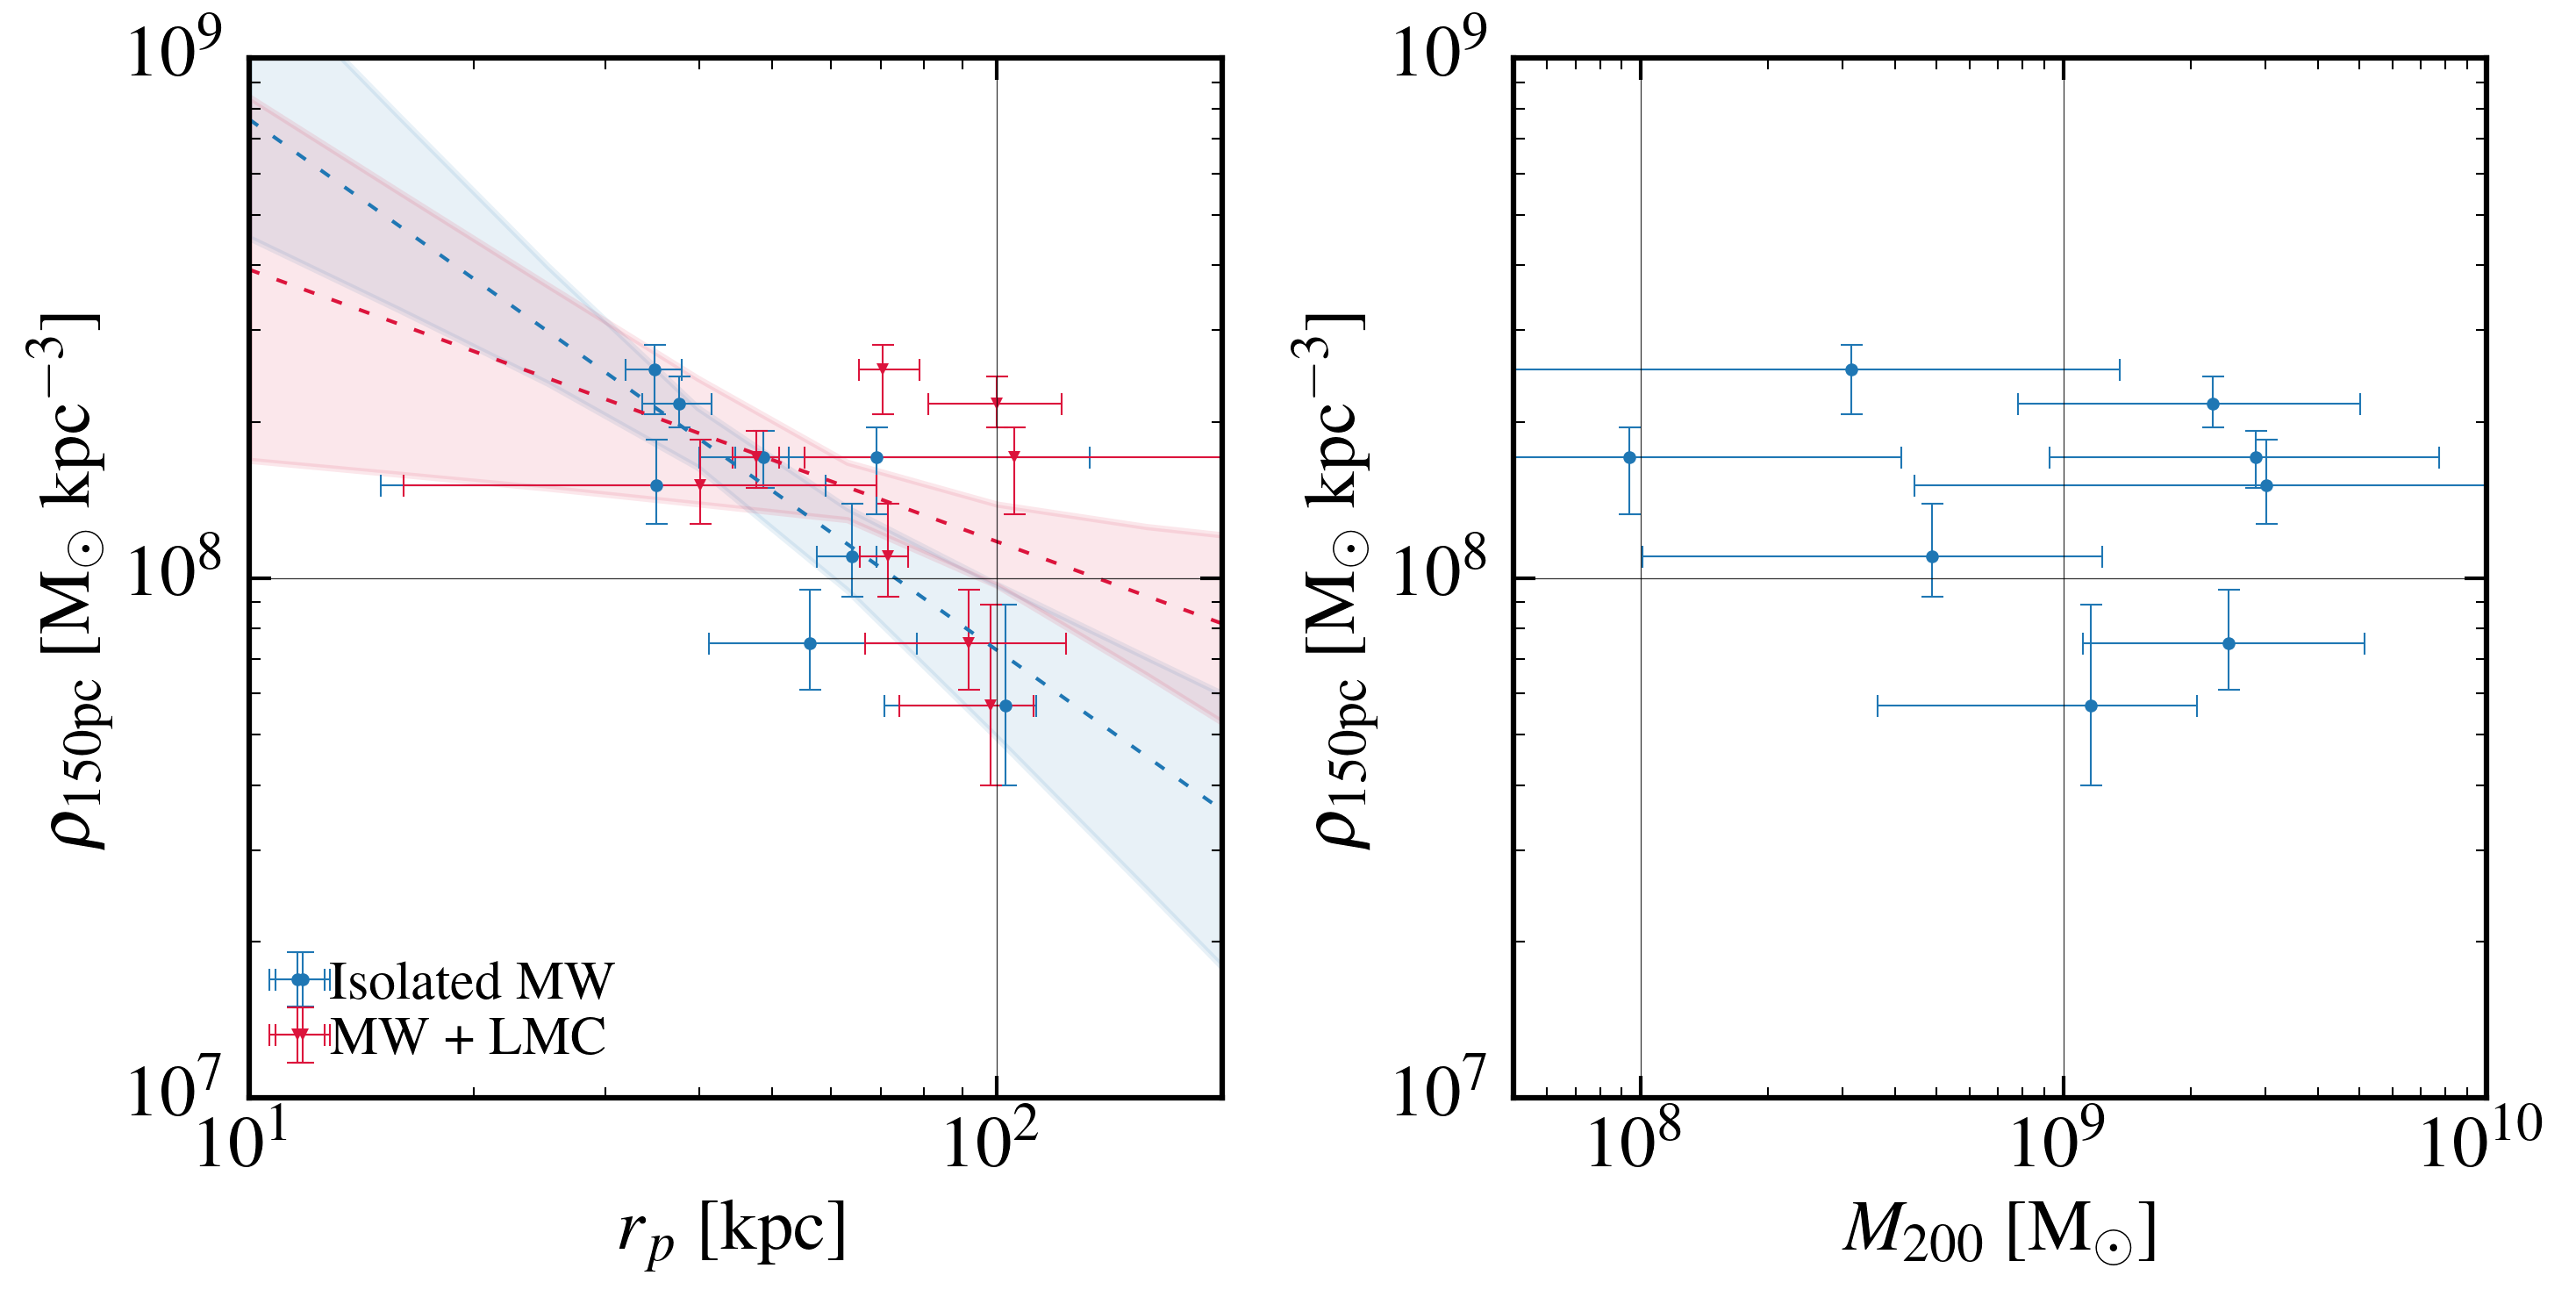

In [6]:
def plot_Gaia_data(axs):
    # Data points
    axs[0].errorbar(r_p_Isolated[0,:], rho_150pc_K19[0,:], xerr=r_p_Isolated[1:,:], yerr=rho_150pc_K19[1:,:],
            marker='o', markersize=3.5, markeredgecolor="none", ls='none', lw=0.5, c='tab:blue',label='Isolated MW')
    axs[0].errorbar(r_p_LMC[0,:], rho_150pc_K19[0,:], xerr=r_p_LMC[1:,:], yerr=rho_150pc_K19[1:,:],
            marker='v', markersize=3.5, markeredgecolor="none", ls='none', lw=0.5, c='crimson',label='MW + LMC')

    # Fit
    xrange = np.arange(np.log10(10), np.log10(500), 0.2)
    num_range = len(xrange)
    for samples, color in zip([samples_isolated, samples_LMC], ["tab:blue", "crimson"]):
        q = np.median(samples[:, 0])
        m = np.median(samples[:, 1])
        yrange = np.ones((2,num_range))
        for i in range(num_range):
            yrange[0, i] = np.percentile(1e7 * 10 ** log_model(xrange[i], samples[:, 0], samples[:, 1]), 16)
            yrange[1, i] = np.percentile(1e7 * 10 ** log_model(xrange[i], samples[:, 0], samples[:, 1]), 84)
        axs[0].fill_between(10 ** xrange, yrange[0,:], yrange[1,:], color=color, alpha=0.1)
        axs[0].plot(10 ** xrange, 1e7 * 10 ** log_model(xrange, q, m), '--', lw=1, color=color)


    axs[0].grid(linestyle='-', linewidth=0.3)
    axs[0].legend(loc=[0.01, 0.01], labelspacing=0.1,
            handlelength=0.7, handletextpad=0.2,
            frameon=False, fontsize=15, ncol=1)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[0].set_ylabel(r"$\rho_{150\mathrm{pc}}$ [M$_{\odot}$ kpc$^{-3}$]")
    axs[0].set_xlabel("$r_{p}$ [kpc]")

    ####
    axs[1].grid(linestyle='-', linewidth=0.3)
    axs[1].errorbar(M200_K19[0,:-1], rho_150pc_K19[0,:], yerr=rho_150pc_K19[1:,:], xerr=M200_K19[1:,:-1],
                marker='o', markersize=3.5, markeredgecolor="none", ls='none', lw=0.5, c='tab:blue')

    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[1].set_ylabel(r"$\rho_{150\mathrm{pc}}$ [M$_{\odot}$ kpc$^{-3}$]")
    axs[1].set_xlabel("$M_{200}$ [M$_{\odot}$]")
    
    
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
plot_Gaia_data(axs)
axs[0].axis([10, 200, 1e7, 1e9])
axs[1].axis([5e7, 1e10, 1e7, 1e9])


## Simulated data (NFW fit)

In [7]:
DATA_PATH = "../data/TangoSIDM/"

IDs = {
    "SigmaConstant00": "CDM",
    "SigmaConstant01": "SigmaConstant01",
    "SigmaConstant10": "SigmaConstant10",
    "SigmaVelDep20Anisotropic": "SigmaVel20",
    "SigmaVelDep60Anisotropic": "SigmaVel60", 
    "SigmaVelDep100Anisotropic": "SigmaVel100",
}

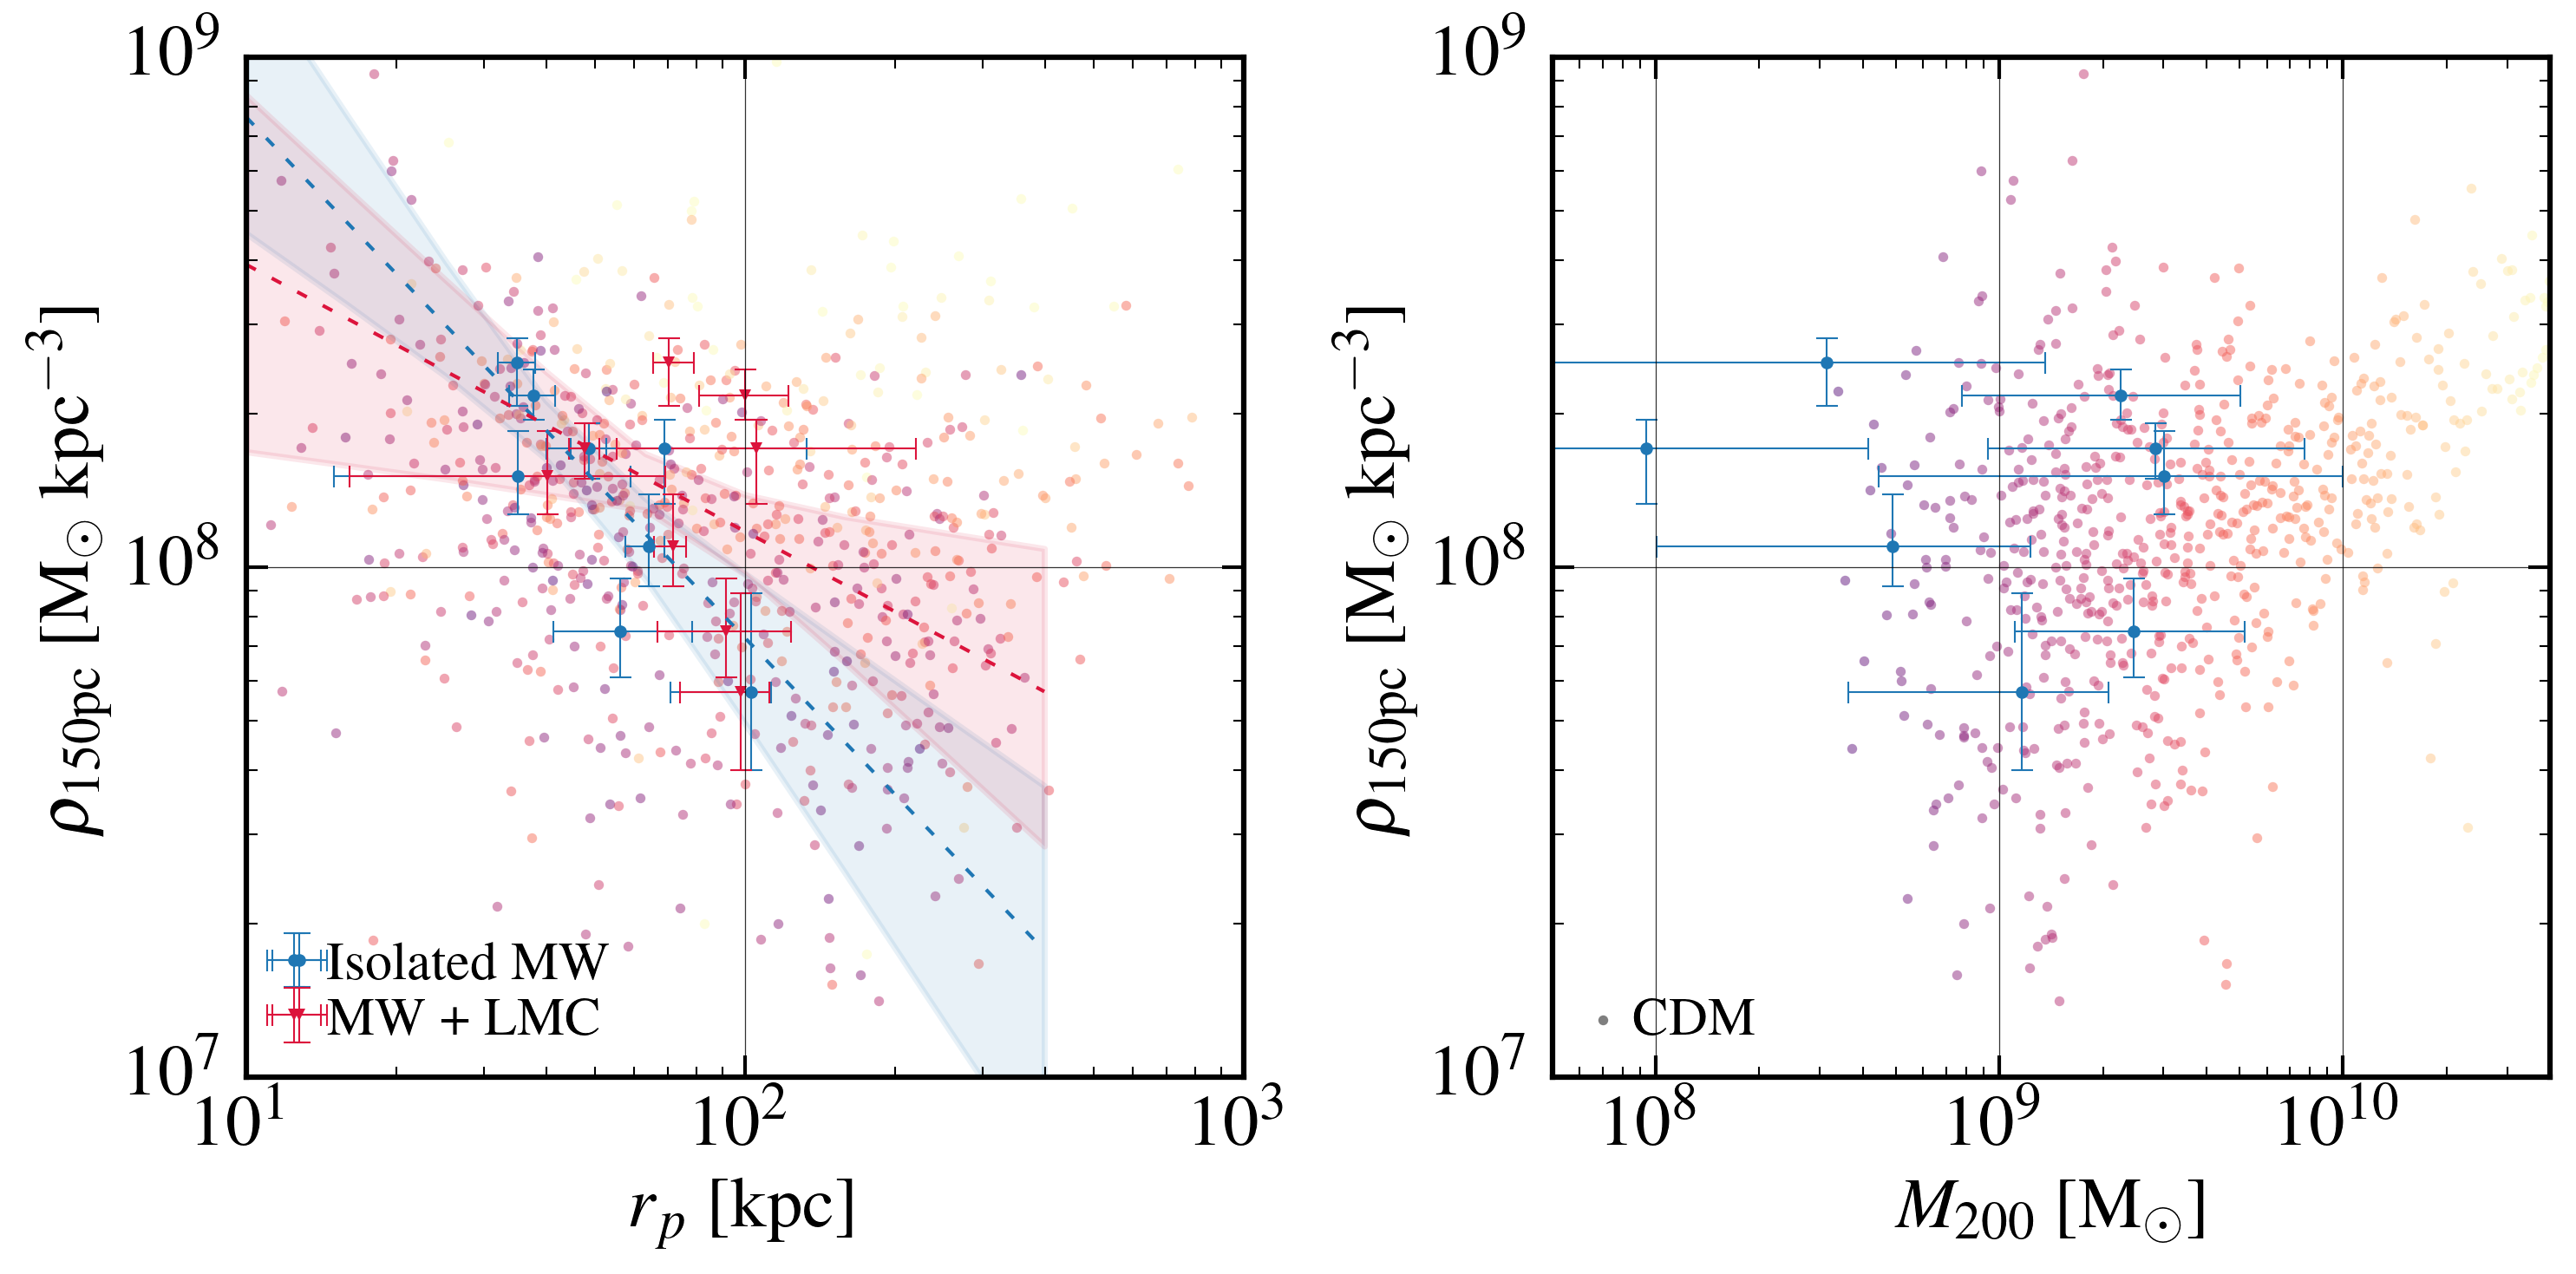

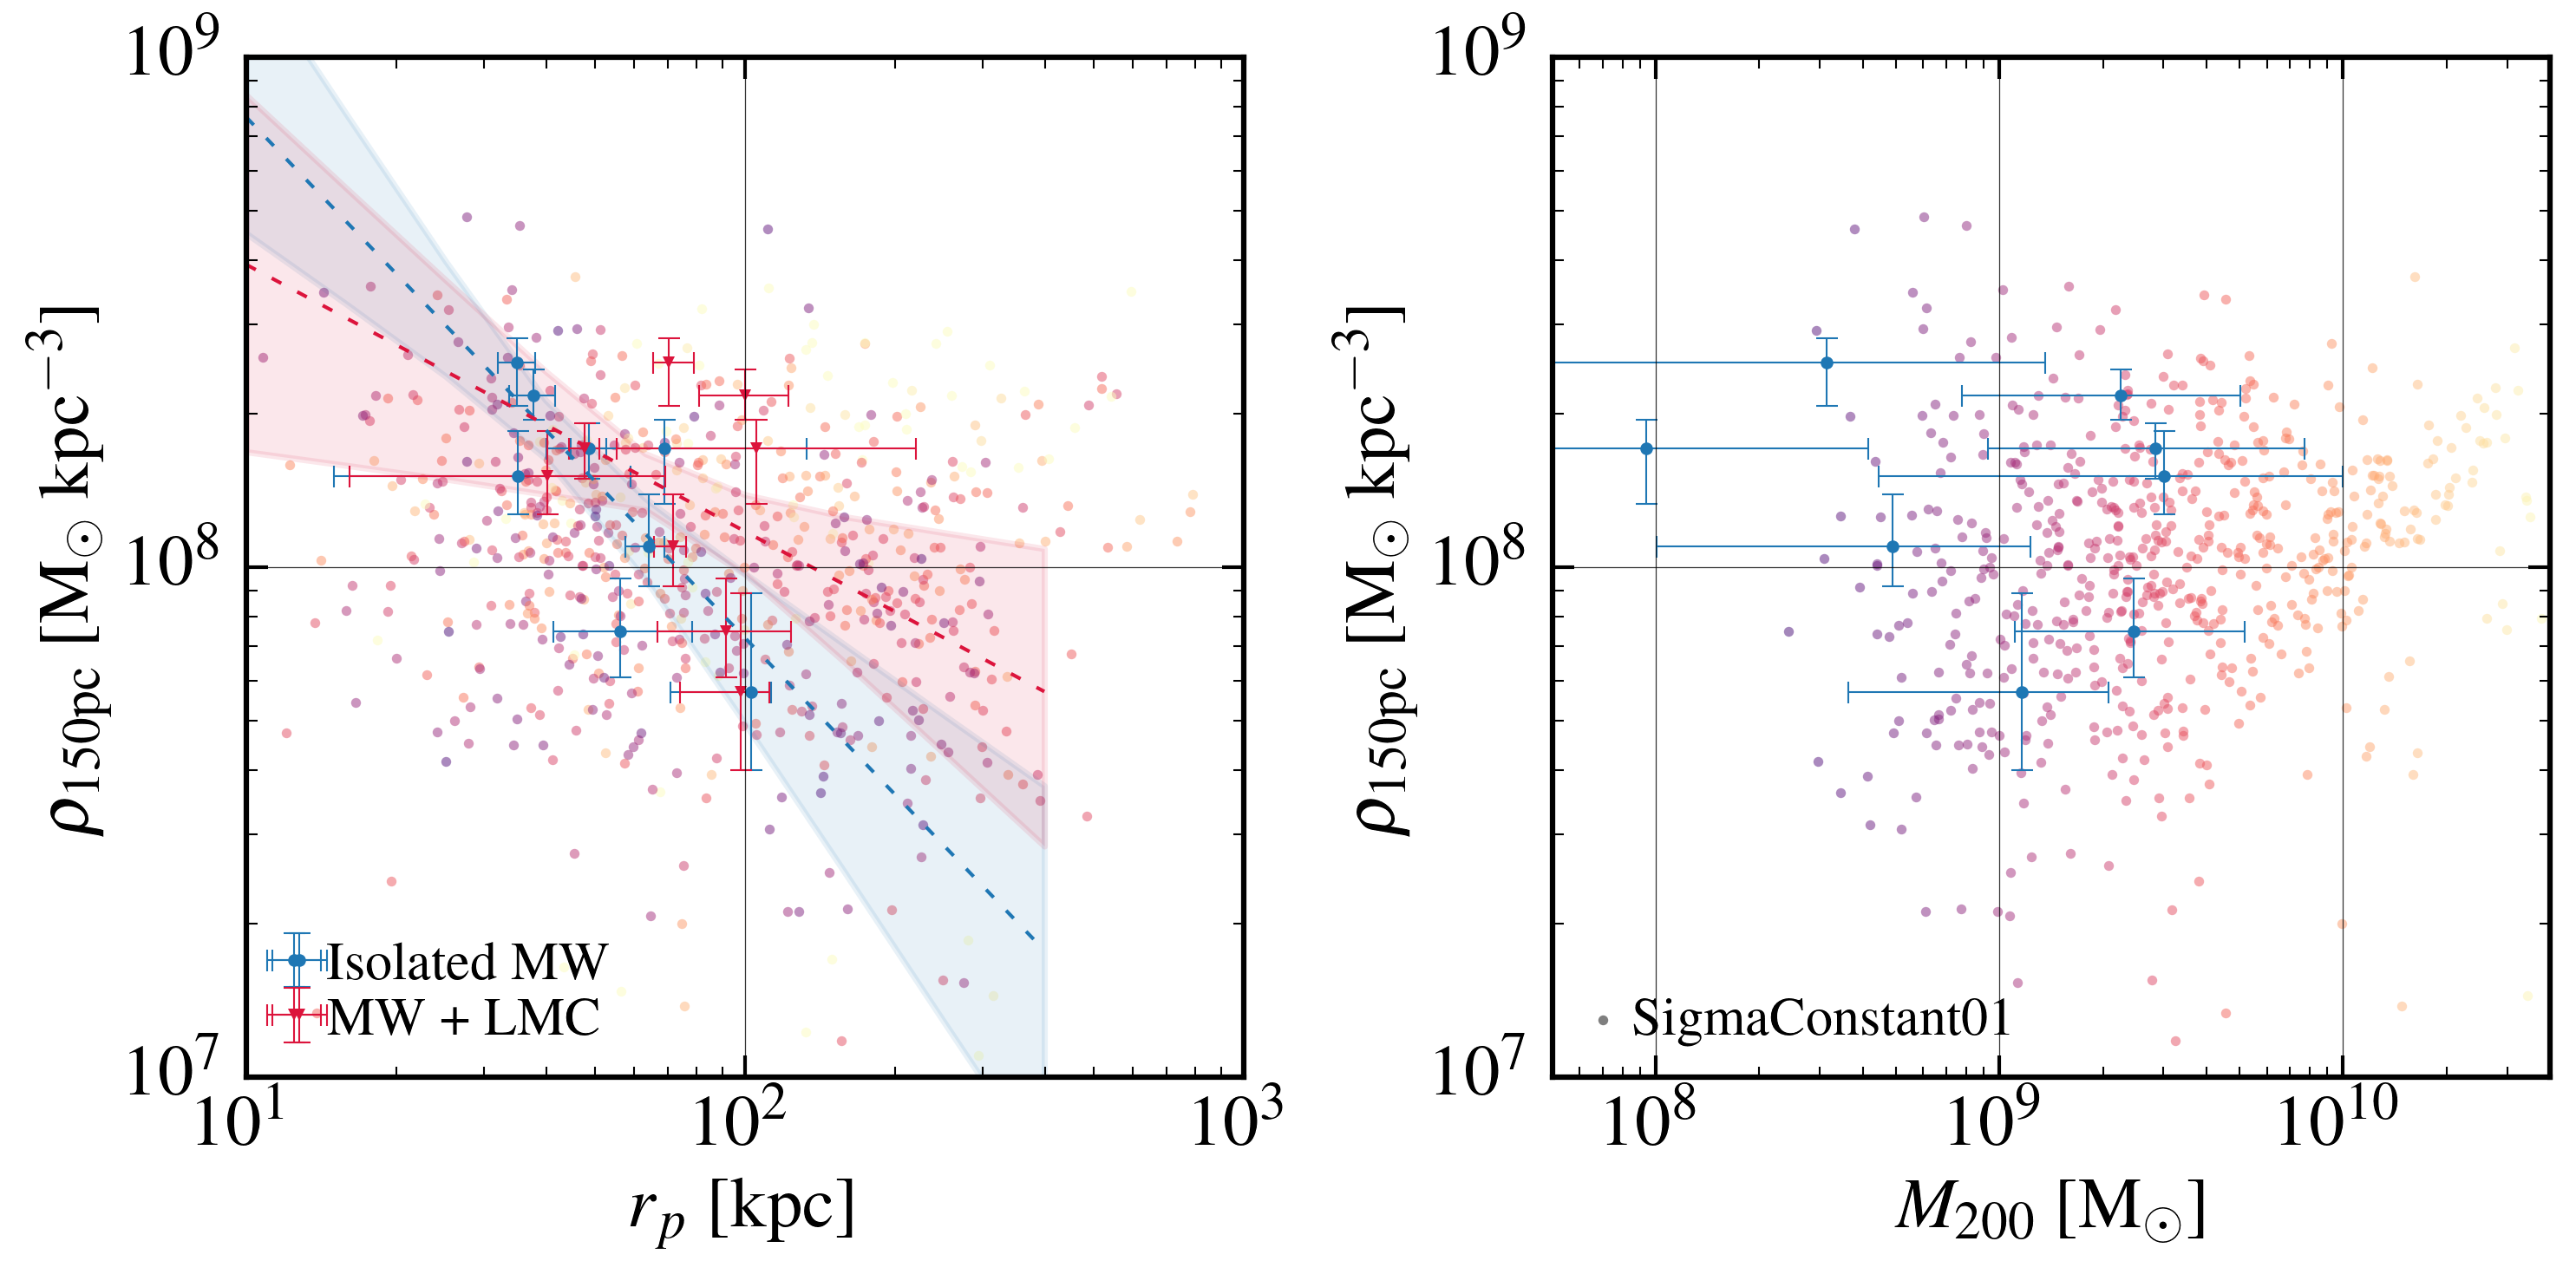

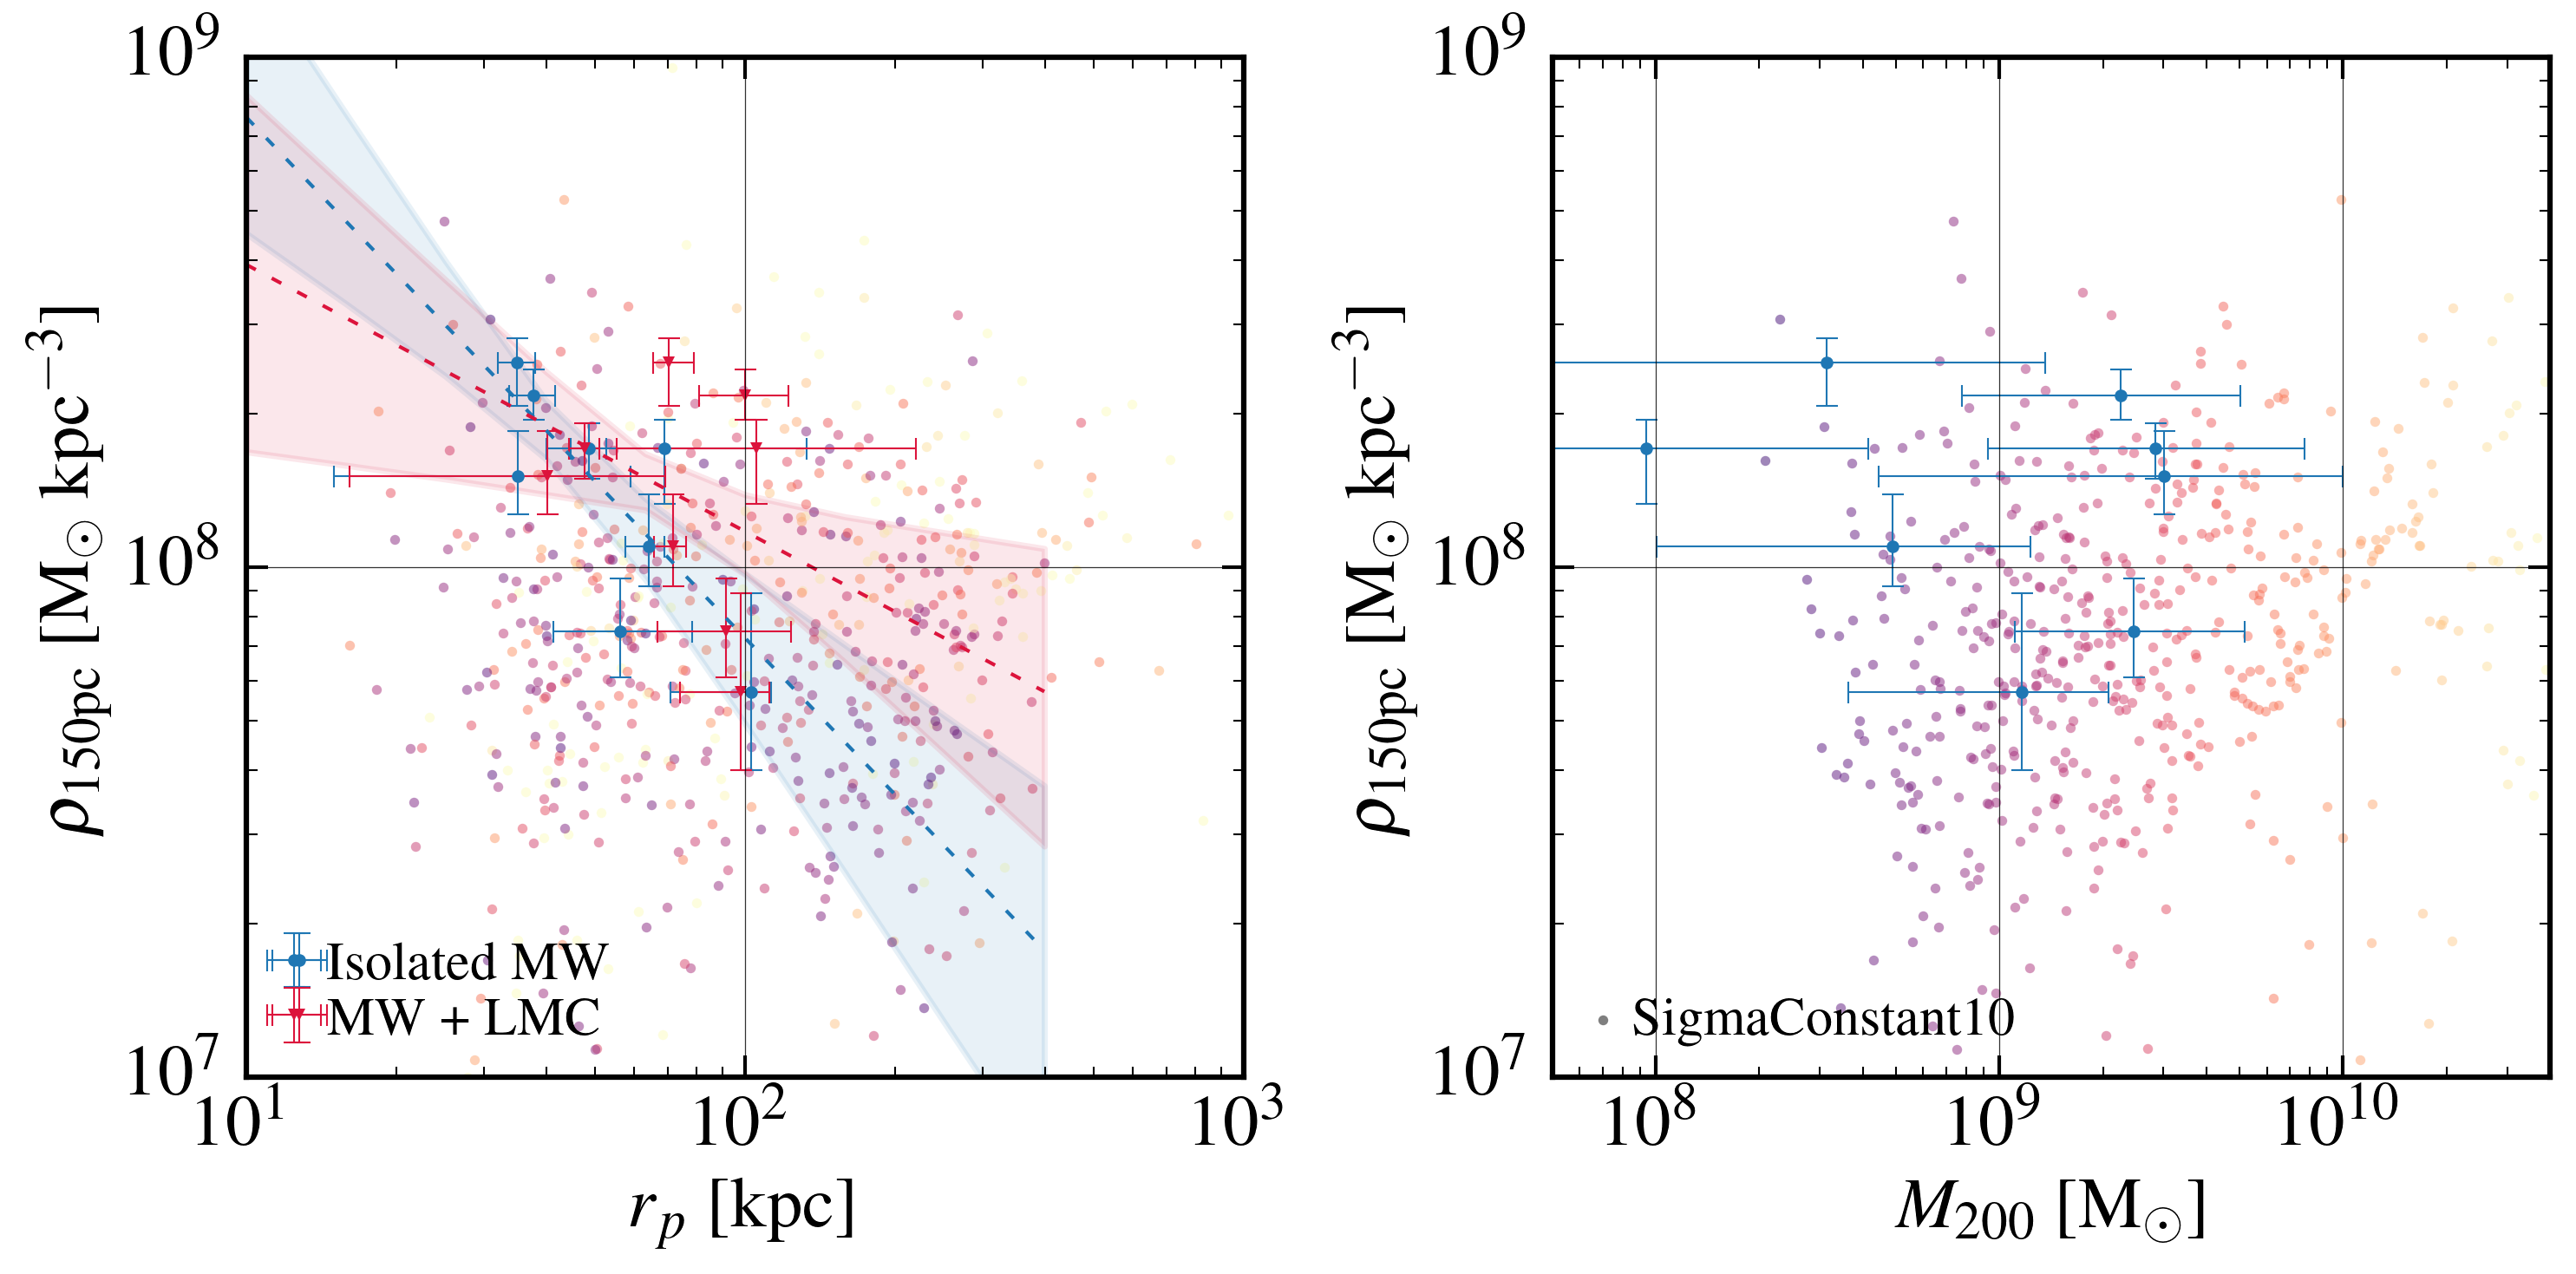

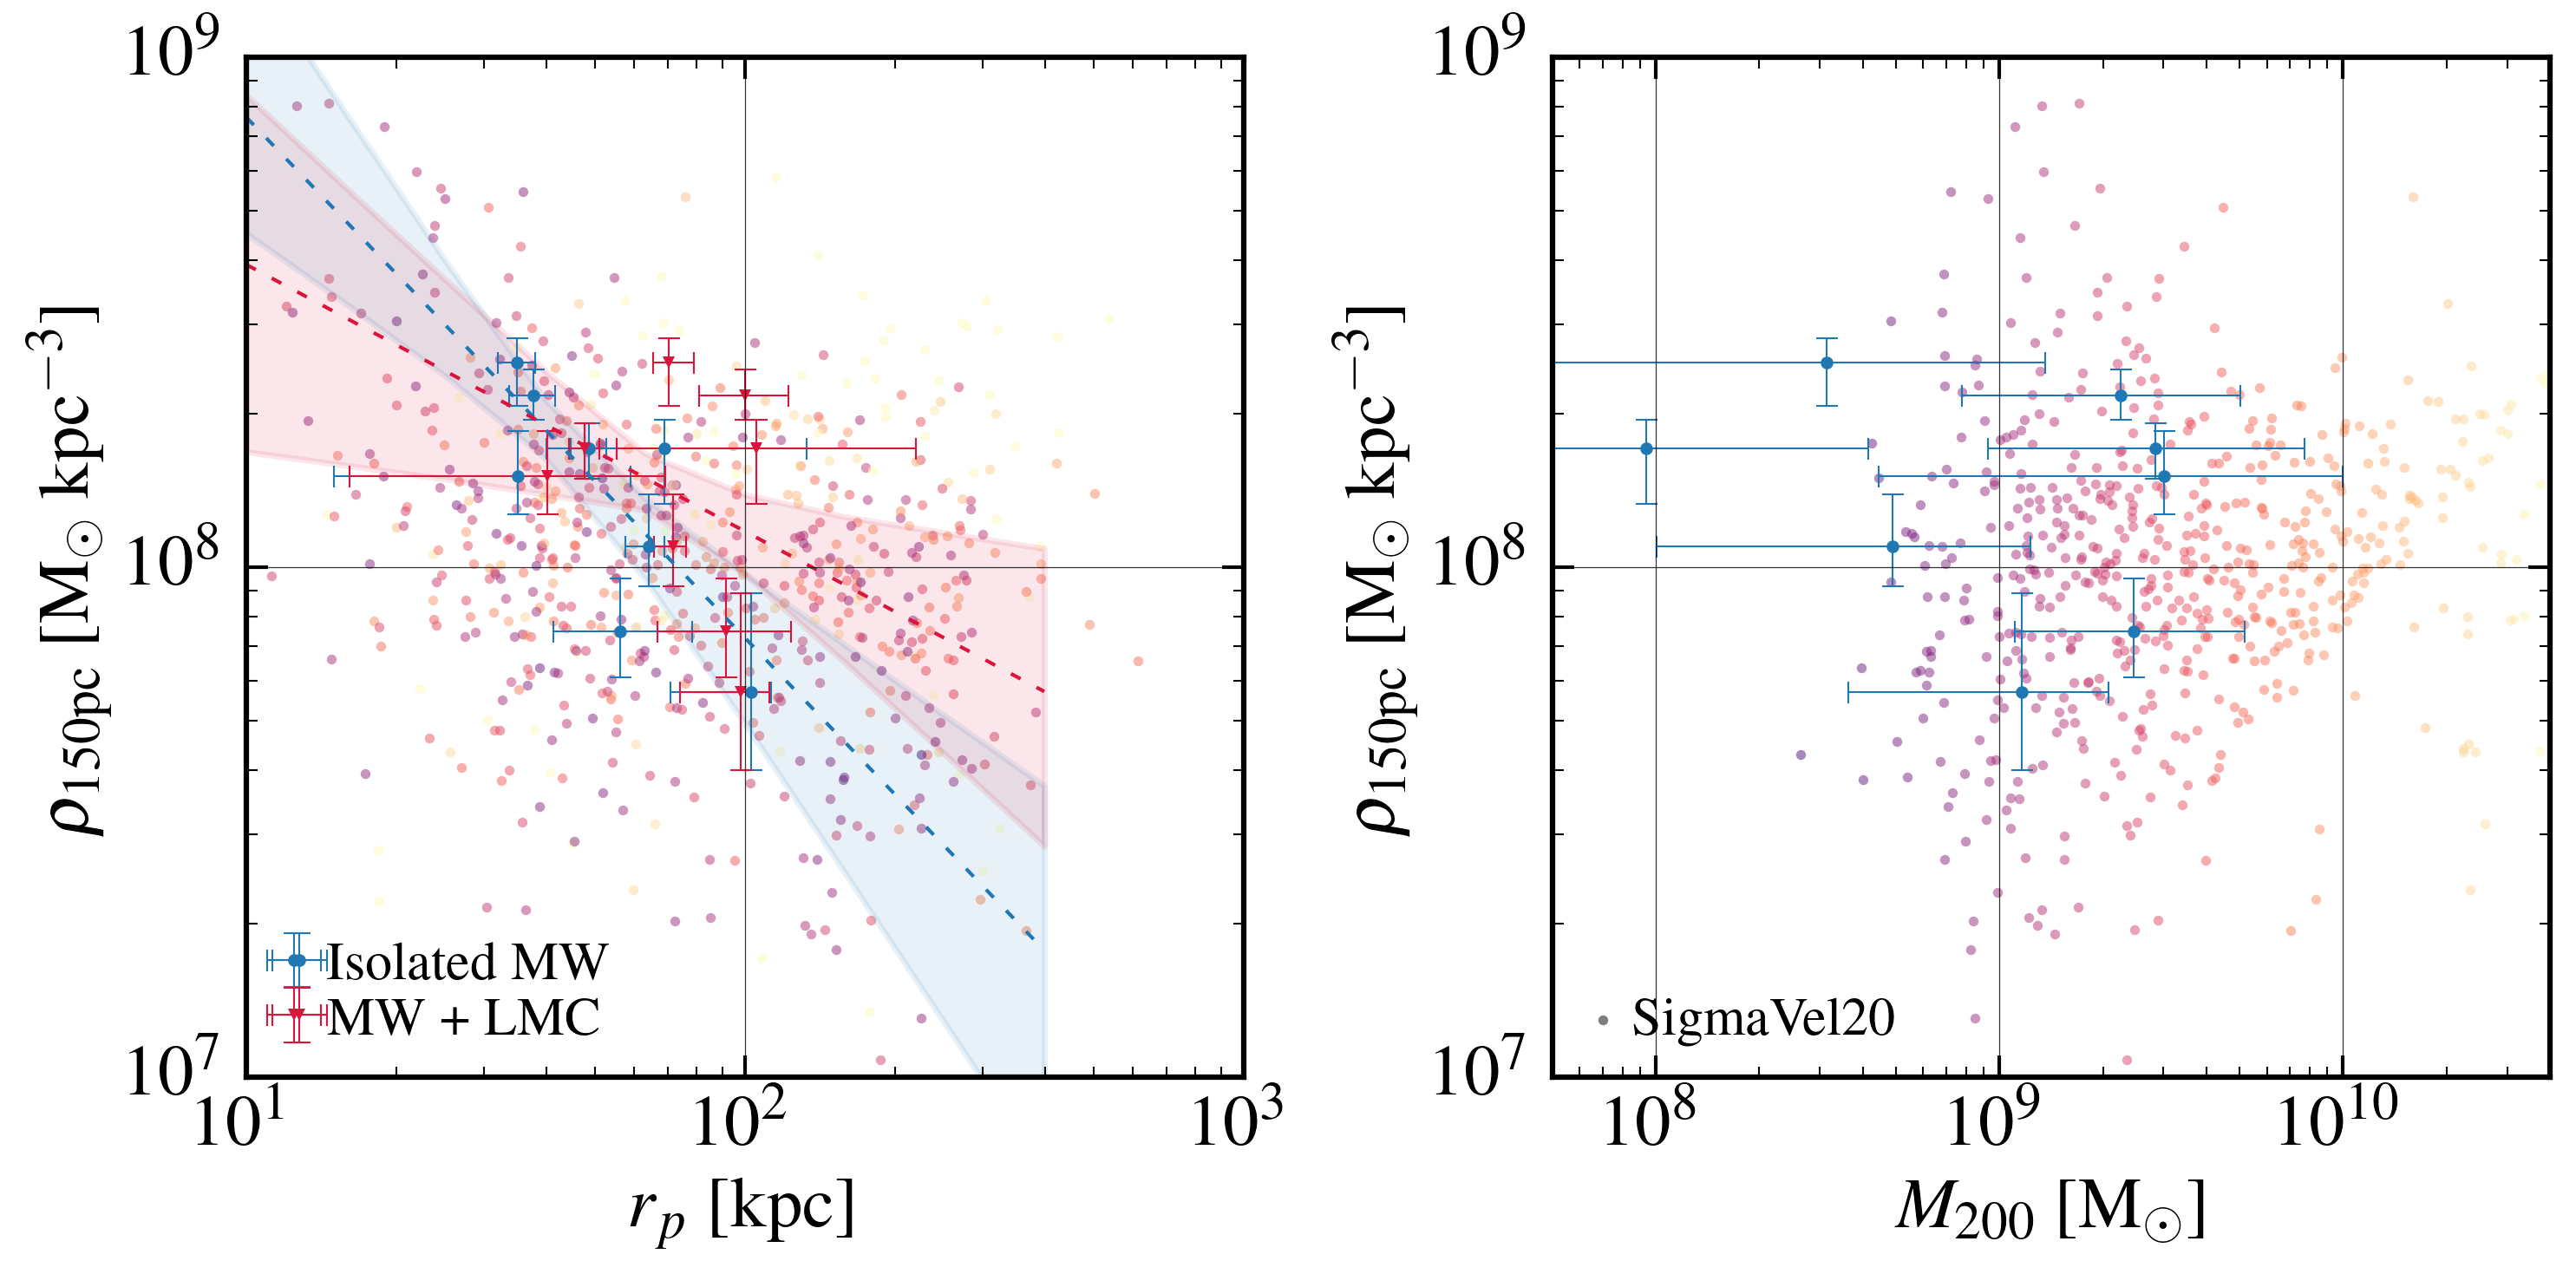

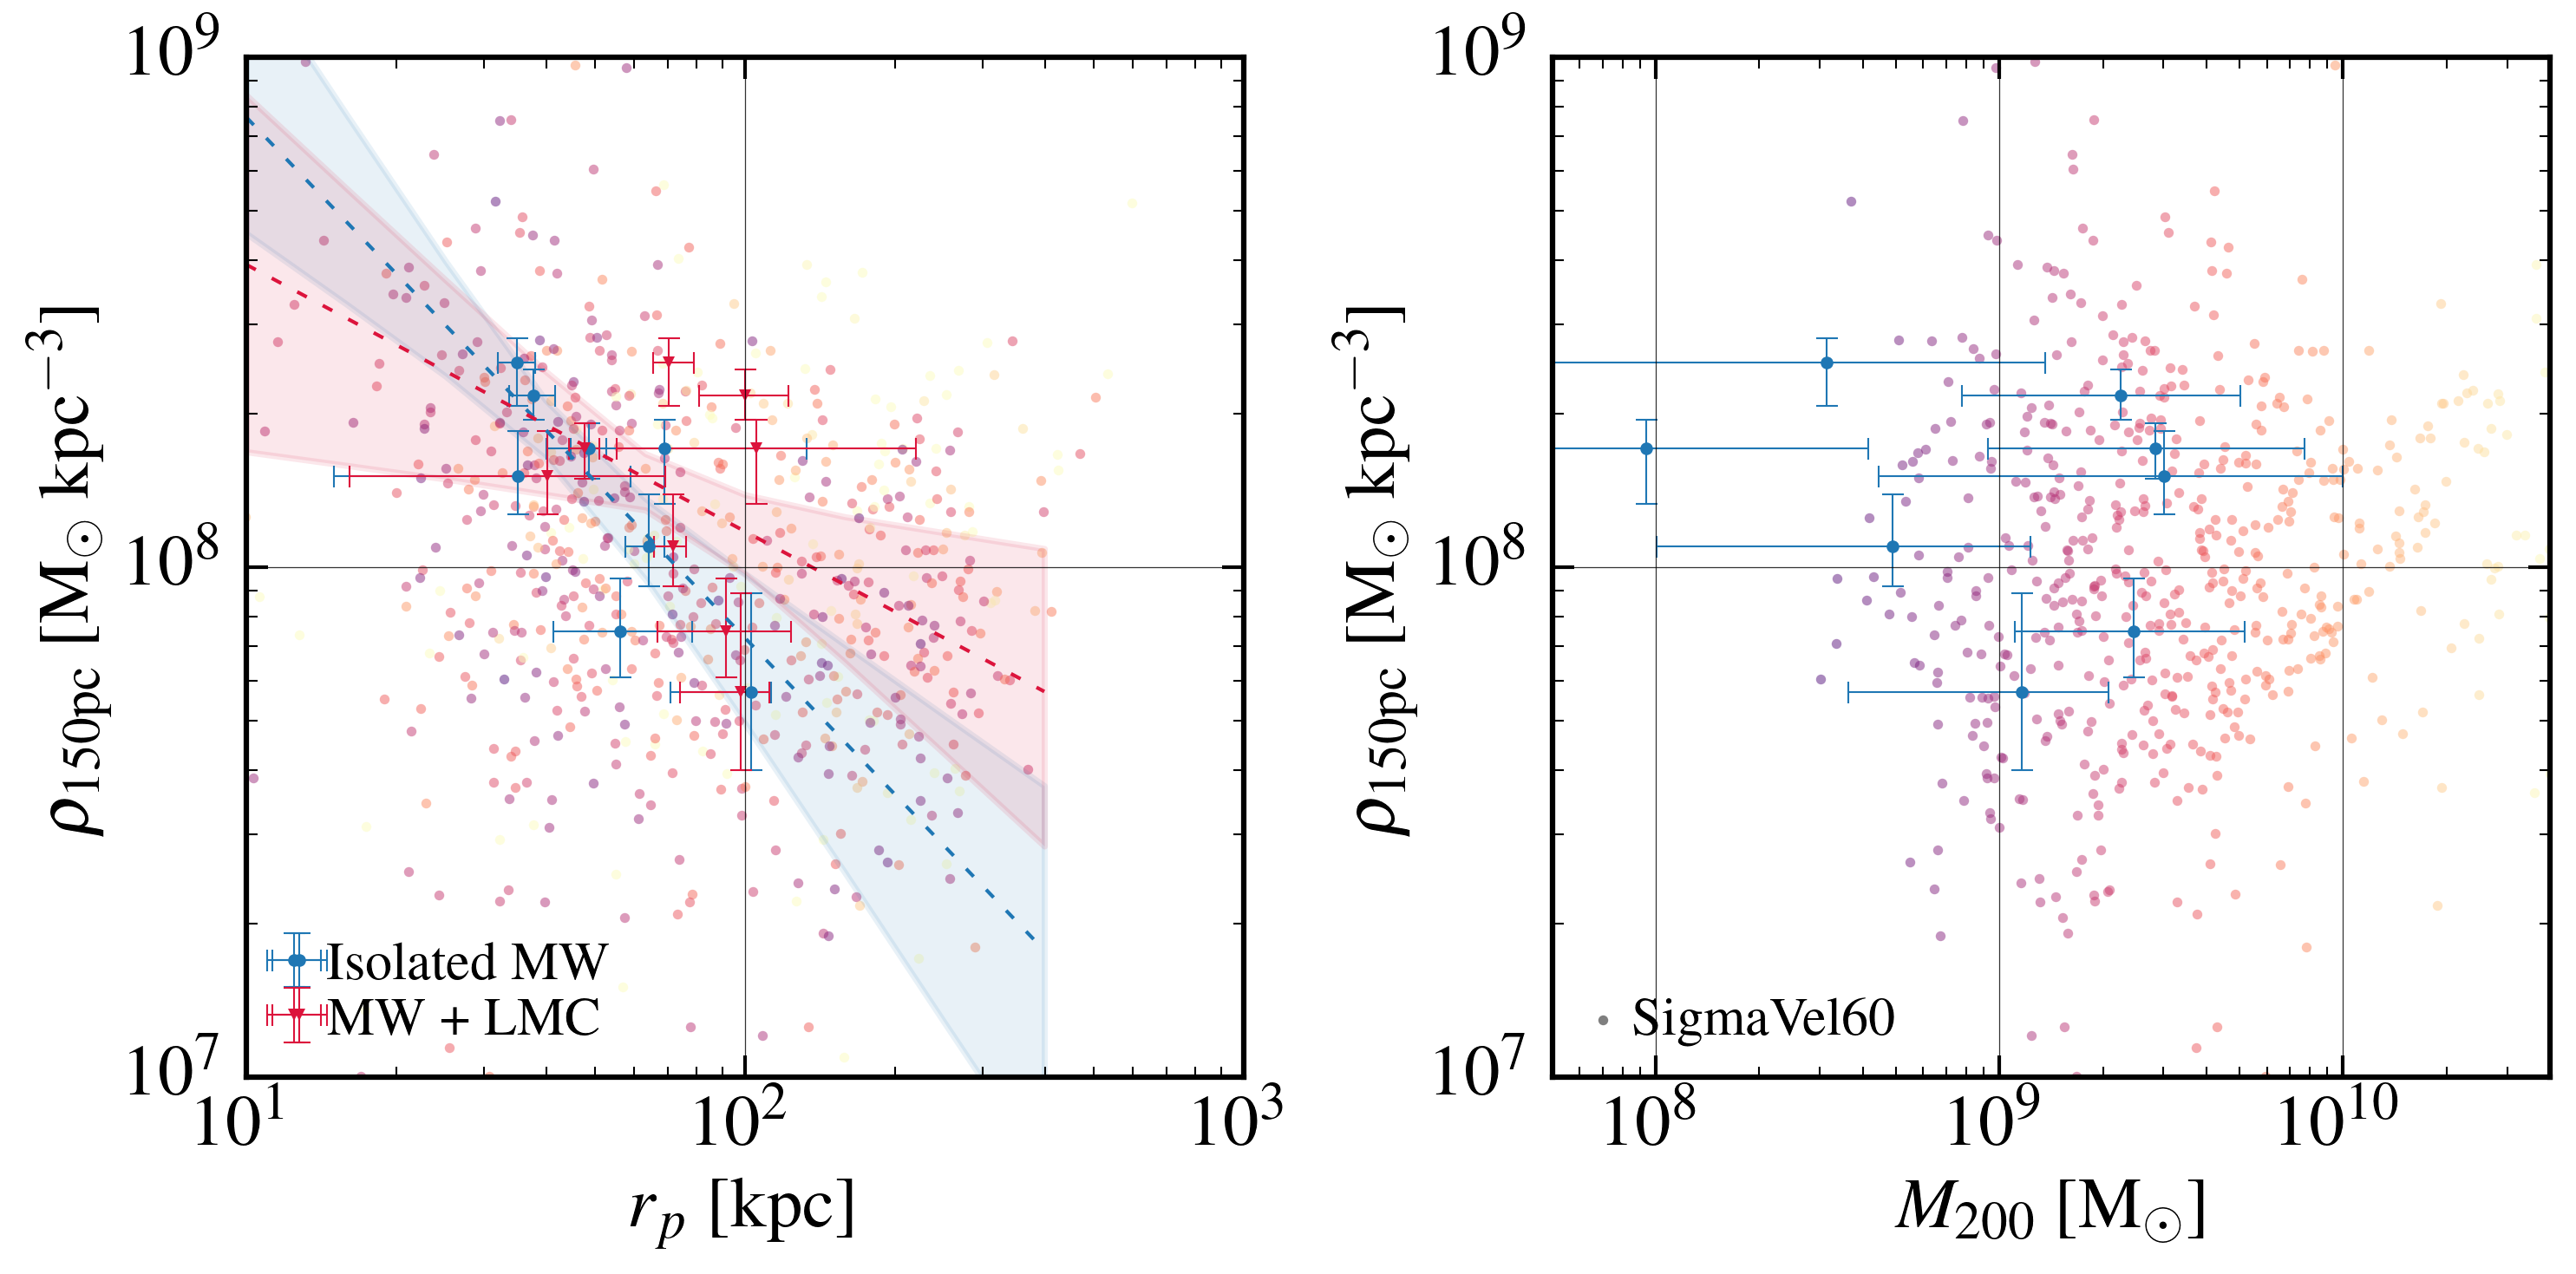

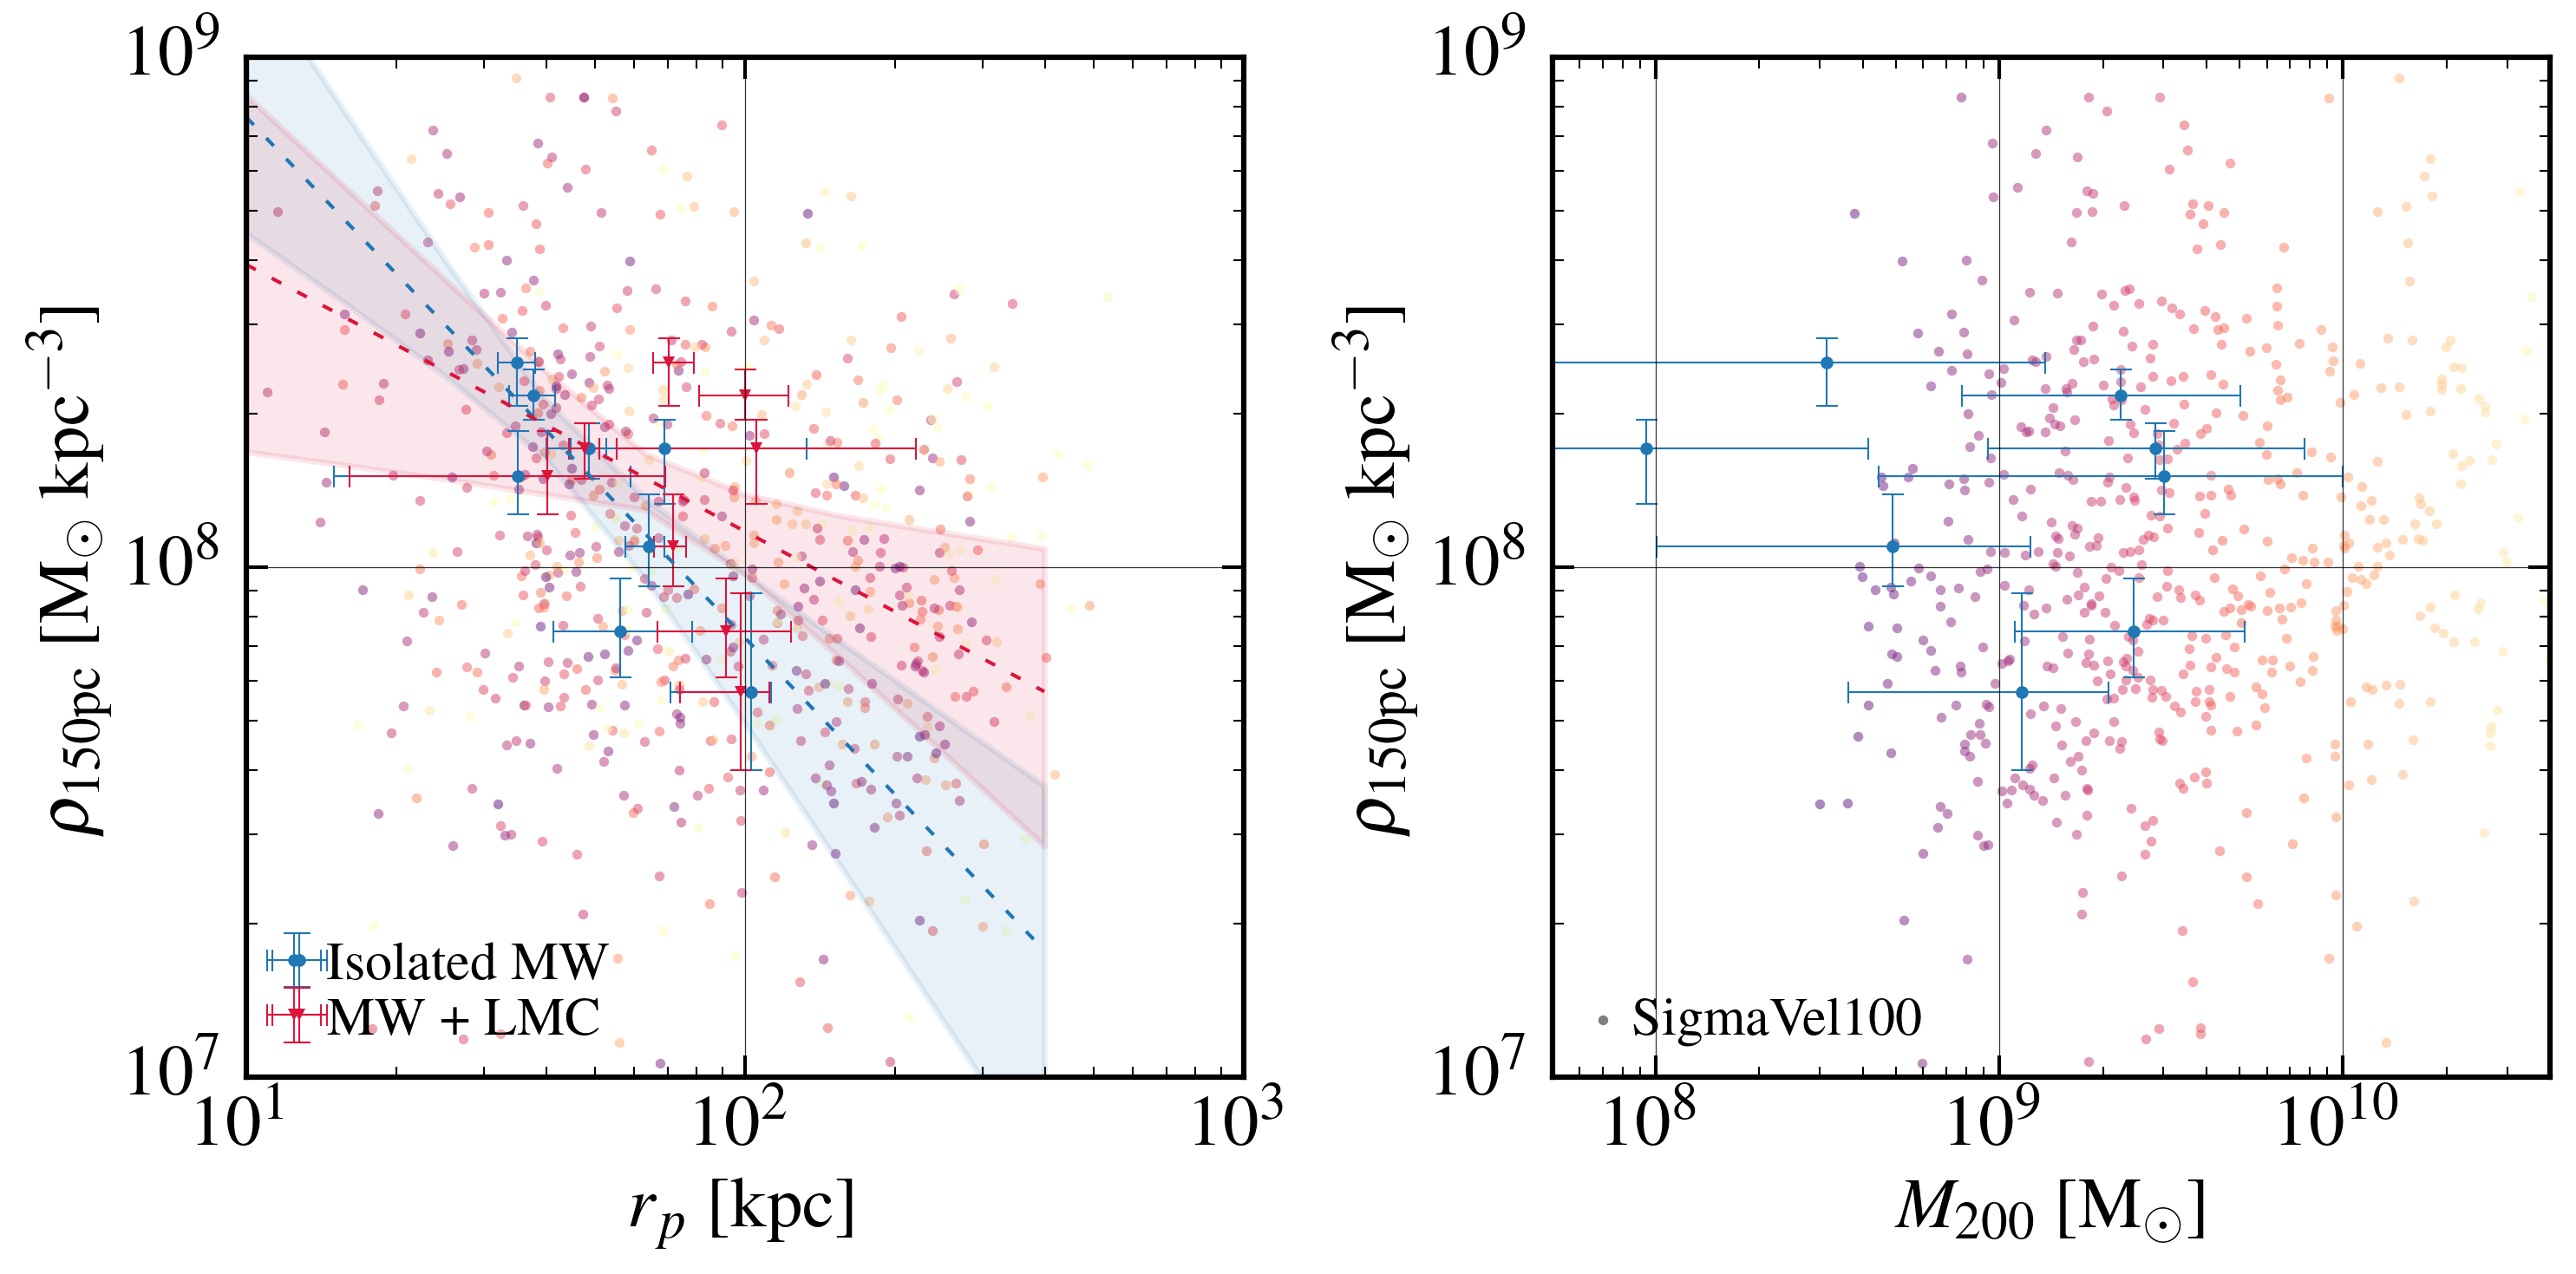

In [11]:
for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

    # Add simulations points
    for idx in file.keys():
        if file[f'{idx}'].attrs.get('subhalo_of') is not None:    
            data_subhalo = file[f'{idx}']
            nfw_fit = data_subhalo['halo_data']['nfw_fit']
            r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
            rho_s = 10**log10_rho_s
            sigma_rho_s = sigma_log10_rho_s * np.log(10) * rho_s
            rho = NFW_profile(r_range, rho_s, r_s)
            mass_within_r = mass(rho, r_range)
            rho_within_r = rho_mean(mass_within_r, r_range)
            R200 = calculate_R200(rho_within_r, r_range)
            M200 = calculate_M200(R200)

            ## Dealing with error propagation..
            error_rho = (sigma_rho_s / rho_s)**2
            error_rho += ( (sigma_r_s / r_s) * ((3. + r_s / r_range) / (1. + r_s / r_range)) )**2
            error_rho *= rho**2
            error_rho = np.sqrt(error_rho)
            
            low_error_rho = rho - error_rho
            mass_within_r = mass(low_error_rho, r_range)
            rho_within_r = rho_mean(mass_within_r, r_range)
            sigma_R200 = calculate_R200(rho_within_r, r_range)
            sigma_M200 = M200 - calculate_M200(R200)
            
            r_p = data_subhalo['tree_data']['pericenter'][1]
            rho_150 = NFW_profile(np.array([0.15]), rho_s, r_s)
            
            axs[0].scatter(r_p, rho_150, c=np.log10(M200), cmap='magma', marker='.', lw=0, vmin=np.log10(5e7), vmax=np.log10(4e10), alpha=0.5, s=30)
            axs[1].scatter(M200, rho_150, c=np.log10(M200), cmap='magma', marker='.', lw=0, vmin=np.log10(5e7), vmax=np.log10(4e10), alpha=0.5, s=30)

    axs[1].scatter([], [], c='k', marker='.', alpha=0.5, s=30, lw=0, label=id_name)
    axs[1].legend(loc=[0.01, 0.01], labelspacing=0.1,
                handlelength=0.7, handletextpad=0.2,
                frameon=False, fontsize=15, ncol=1)
    
    axs[0].axis([10, 1e3, 1e7, 1e9])
    axs[1].axis([5e7, 4e10, 1e7, 1e9])

    # Add Gaia data
    plot_Gaia_data(axs)

    ####
    plt.tight_layout()
    plt.show()
    
    file.close()